Epoch [10/200], Loss: 0.6843
Epoch [20/200], Loss: 0.6788
Epoch [30/200], Loss: 0.6727
Epoch [40/200], Loss: 0.6805
Epoch [50/200], Loss: 0.6785
Epoch [60/200], Loss: 0.6636
Epoch [70/200], Loss: 0.6427
Epoch [80/200], Loss: 0.6556
Epoch [90/200], Loss: 0.6534
Epoch [100/200], Loss: 0.6503
Epoch [110/200], Loss: 0.6341
Epoch [120/200], Loss: 0.6438
Epoch [130/200], Loss: 0.6370
Epoch [140/200], Loss: 0.6252
Epoch [150/200], Loss: 0.6229
Epoch [160/200], Loss: 0.6441
Epoch [170/200], Loss: 0.6318
Epoch [180/200], Loss: 0.6345
Epoch [190/200], Loss: 0.6249
Epoch [200/200], Loss: 0.6202

Model Evaluation:
Accuracy: 0.5204
Precision: 0.5208
Recall: 0.5204
F1-Score: 0.5179

Classification Report:
              precision    recall  f1-score   support

     Control       0.52      0.59      0.55        49
          PD       0.52      0.45      0.48        49

    accuracy                           0.52        98
   macro avg       0.52      0.52      0.52        98
weighted avg       0.52    

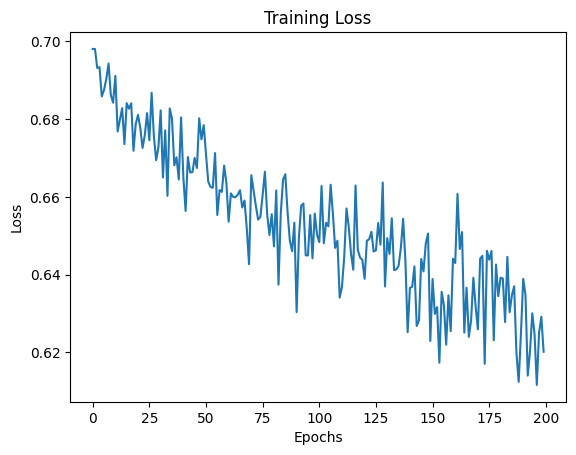

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Step 1: Load and preprocess the data
# Load the dataset
file_path = 'extracted_features.csv'
data = pd.read_csv(file_path)

# Select features and labels
features = ['Mean_Intensity', 'Std_Intensity', 'Skewness', 'Kurtosis'] + [f'Haralick_{i}' for i in range(13)]
X = data[features].values  # Feature matrix
y = data['Label'].factorize()[0]  # Convert labels to numerical values (e.g., Control -> 0, PD -> 1)

# Handle missing values by filling with the median
X = pd.DataFrame(X, columns=features)
X = X.fillna(X.median())  # Replace NaN with the median
X = X.values  # Convert back to NumPy array

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Step 3: Build the CNN model
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # Fully connected layer 1
        self.bn1 = nn.BatchNorm1d(128)  # Batch normalization
        self.fc2 = nn.Linear(128, 64)  # Fully connected layer 2
        self.bn2 = nn.BatchNorm1d(64)  # Batch normalization
        self.fc3 = nn.Linear(64, 32)  # Fully connected layer 3
        self.fc4 = nn.Linear(32, num_classes)  # Output layer
        self.relu = nn.LeakyReLU()  # LeakyReLU activation
        self.dropout = nn.Dropout(0.4)  # Dropout for regularization

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model
input_dim = X_train.shape[1]  # Number of features
num_classes = len(np.unique(y))  # Number of unique classes
model = CNNModel(input_dim, num_classes)

# Step 4: Train the CNN model
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Add weight decay for regularization

# Training loop
num_epochs = 200
losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Print loss for every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Step 5: Evaluate the model
model.eval()
with torch.no_grad():
    # Get predictions
    test_outputs = model(X_test)
    _, y_pred = torch.max(test_outputs, 1)  # Get predicted class labels

# Compute evaluation metrics
accuracy = accuracy_score(y_test.numpy(), y_pred.numpy())
precision = precision_score(y_test.numpy(), y_pred.numpy(), average='weighted')
recall = recall_score(y_test.numpy(), y_pred.numpy(), average='weighted')
f1 = f1_score(y_test.numpy(), y_pred.numpy(), average='weighted')

# Print evaluation metrics
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test.numpy(), y_pred.numpy(), target_names=data['Label'].unique()))

# Optional: Plot the training loss
import matplotlib.pyplot as plt
plt.plot(range(num_epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


Logistic Regression Classification Report:
              precision    recall  f1-score   support

     Control       0.47      0.51      0.49        49
          PD       0.47      0.43      0.45        49

    accuracy                           0.47        98
   macro avg       0.47      0.47      0.47        98
weighted avg       0.47      0.47      0.47        98


SVM (Linear Kernel) Classification Report:
              precision    recall  f1-score   support

     Control       0.48      0.59      0.53        49
          PD       0.46      0.35      0.40        49

    accuracy                           0.47        98
   macro avg       0.47      0.47      0.46        98
weighted avg       0.47      0.47      0.46        98


Random Forest Classification Report:
              precision    recall  f1-score   support

     Control       0.65      0.63      0.64        49
          PD       0.64      0.65      0.65        49

    accuracy                           0.64        98
  

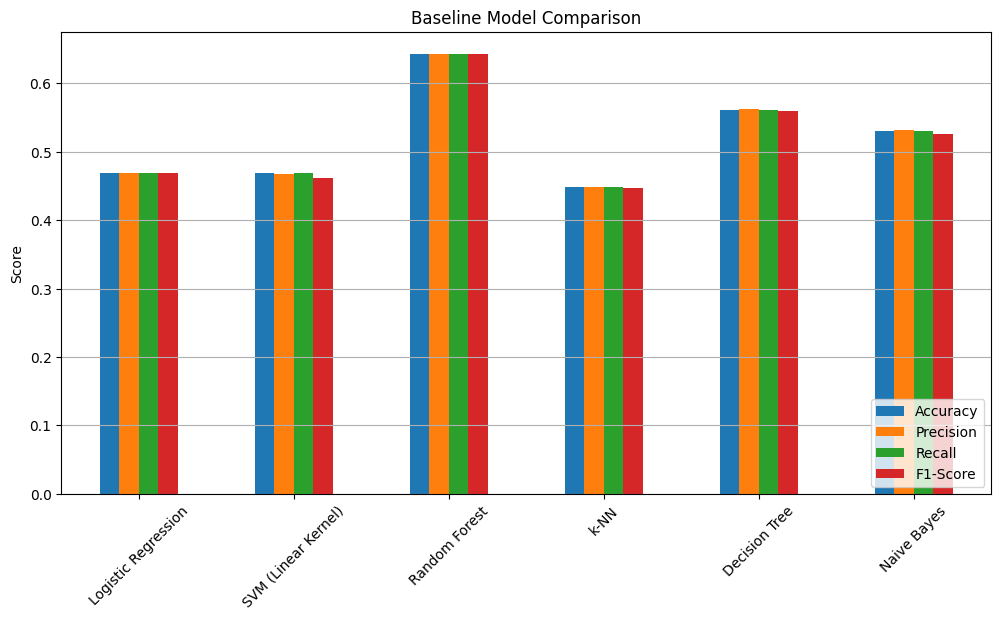

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the data
# Load the dataset
file_path = '/Users/konkimk/Desktop/cap_dataset/extracted_features.csv'
data = pd.read_csv(file_path)

# Select features and labels
features = ['Mean_Intensity', 'Std_Intensity', 'Skewness', 'Kurtosis'] + [f'Haralick_{i}' for i in range(13)]
X = data[features].values  # Feature matrix
y = data['Label'].factorize()[0]  # Convert labels to numerical values (e.g., Control -> 0, PD -> 1)

# Handle missing values by filling with the median
X = pd.DataFrame(X, columns=features)
X = X.fillna(X.median())  # Replace NaN with the median
X = X.values  # Convert back to NumPy array

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Define baseline models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (Linear Kernel)": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

# Step 3: Train and evaluate each model
results = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store the results
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }
    
    # Print the classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=data['Label'].unique()))

# Step 4: Compare results
print("\nModel Comparison:")
comparison_df = pd.DataFrame(results).T  # Convert results to a DataFrame
print(comparison_df)

# Step 5: Visualize the results
comparison_df.plot(kind='bar', figsize=(12, 6))
plt.title("Baseline Model Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()

In [5]:
print(data['Label'].value_counts())

Label
PD         248
Control    240
Name: count, dtype: int64


In [6]:
print(data[features].var())

Mean_Intensity    2.127078e-33
Std_Intensity     1.341877e-32
Skewness          1.599334e+01
Kurtosis          1.182835e+04
Haralick_0        1.104523e-02
Haralick_1        9.856346e+06
Haralick_2        4.932704e-03
Haralick_3        2.813164e+06
Haralick_4        3.120047e-02
Haralick_5        3.234051e+03
Haralick_6        1.298802e+07
Haralick_7        6.264022e-01
Haralick_8        1.694244e+00
Haralick_9        1.194626e-07
Haralick_10       4.394809e-01
Haralick_11       9.726573e-03
Haralick_12       6.432896e-02
dtype: float64


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load and preprocess the data
file_path = '/Users/konkimk/Desktop/cap_dataset/extracted_features.csv'
data = pd.read_csv(file_path)

# Select features and labels
features = ['Mean_Intensity', 'Std_Intensity', 'Skewness', 'Kurtosis'] + [f'Haralick_{i}' for i in range(13)]
X = data[features].values
y = data['Label'].factorize()[0]

# Handle missing values by filling with the median
X = pd.DataFrame(X, columns=features)
X = X.fillna(X.median())  # Replace NaN with the median
X = X.values  # Convert back to NumPy array

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add sequence dimension
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)  # h_n is the hidden state
        x = self.fc(h_n.squeeze(0))  # Pass through fully connected layer
        return x

# Initialize the model
input_dim = X_train.shape[2]
hidden_dim = 64
num_classes = len(np.unique(y))
model = LSTMModel(input_dim, hidden_dim, num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test).argmax(dim=1)
    accuracy = (y_pred == y_test).float().mean()
    print(f"Test Accuracy: {accuracy:.4f}")

Epoch [10/200], Loss: 0.6928
Epoch [20/200], Loss: 0.6879
Epoch [30/200], Loss: 0.6833
Epoch [40/200], Loss: 0.6782
Epoch [50/200], Loss: 0.6729
Epoch [60/200], Loss: 0.6680
Epoch [70/200], Loss: 0.6636
Epoch [80/200], Loss: 0.6596
Epoch [90/200], Loss: 0.6557
Epoch [100/200], Loss: 0.6515
Epoch [110/200], Loss: 0.6473
Epoch [120/200], Loss: 0.6429
Epoch [130/200], Loss: 0.6385
Epoch [140/200], Loss: 0.6341
Epoch [150/200], Loss: 0.6297
Epoch [160/200], Loss: 0.6253
Epoch [170/200], Loss: 0.6207
Epoch [180/200], Loss: 0.6158
Epoch [190/200], Loss: 0.6106
Epoch [200/200], Loss: 0.6051
Test Accuracy: 0.5408


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb

# Step 1: Load and preprocess the data
file_path = 'extracted_features.csv'
data = pd.read_csv(file_path)

# Select features and labels
features = ['Mean_Intensity', 'Std_Intensity', 'Skewness', 'Kurtosis'] + [f'Haralick_{i}' for i in range(13)]
X = data[features].values
y = data['Label'].factorize()[0]  # Convert labels to numerical values (e.g., Control -> 0, PD -> 1)

# Handle missing values by filling with the median
X = pd.DataFrame(X, columns=features)
X = X.fillna(X.median())  # Replace NaN with the median
X = X.values  # Convert back to NumPy array

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Step 2: Define the MLP model for feature extraction
class MLPFeatureExtractor(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(MLPFeatureExtractor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, embedding_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Output embeddings
        return x

# Initialize the MLP model
input_dim = X_train.shape[1]
embedding_dim = 64  # Size of the extracted embeddings
mlp_model = MLPFeatureExtractor(input_dim, embedding_dim)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Step 3: Train the MLP model
num_epochs = 200
for epoch in range(num_epochs):
    mlp_model.train()
    optimizer.zero_grad()
    embeddings = mlp_model(X_train_tensor)
    loss = criterion(embeddings, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Extract embeddings for training and testing data
mlp_model.eval()
with torch.no_grad():
    train_embeddings = mlp_model(X_train_tensor).numpy()
    test_embeddings = mlp_model(X_test_tensor).numpy()

# Step 4: Train an XGBoost classifier on the extracted embeddings
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(train_embeddings, y_train)

# Step 5: Evaluate the hybrid model
y_pred = xgb_model.predict(test_embeddings)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nHybrid Model Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=data['Label'].unique()))

Epoch [10/200], Loss: 3.5639
Epoch [20/200], Loss: 2.8375
Epoch [30/200], Loss: 2.1224
Epoch [40/200], Loss: 1.5478
Epoch [50/200], Loss: 1.1849
Epoch [60/200], Loss: 0.9476
Epoch [70/200], Loss: 0.8501
Epoch [80/200], Loss: 0.8035
Epoch [90/200], Loss: 0.8054
Epoch [100/200], Loss: 0.7820
Epoch [110/200], Loss: 0.7430
Epoch [120/200], Loss: 0.7328
Epoch [130/200], Loss: 0.7349
Epoch [140/200], Loss: 0.7187
Epoch [150/200], Loss: 0.7188
Epoch [160/200], Loss: 0.7191
Epoch [170/200], Loss: 0.7040
Epoch [180/200], Loss: 0.7218
Epoch [190/200], Loss: 0.6943
Epoch [200/200], Loss: 0.6979

Hybrid Model Test Accuracy: 0.5918

Classification Report:
              precision    recall  f1-score   support

     Control       0.61      0.51      0.56        49
          PD       0.58      0.67      0.62        49

    accuracy                           0.59        98
   macro avg       0.59      0.59      0.59        98
weighted avg       0.59      0.59      0.59        98



In [13]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb

# Step 1: Load and preprocess the data
file_path = 'extracted_features.csv'
data = pd.read_csv(file_path)

# Select features and labels
features = ['Mean_Intensity', 'Std_Intensity', 'Skewness', 'Kurtosis'] + [f'Haralick_{i}' for i in range(13)]
X = data[features].values
y = data['Label'].factorize()[0]  # Convert labels to numerical values (e.g., Control -> 0, PD -> 1)

# Handle missing values by filling with the median
X = pd.DataFrame(X, columns=features)
X = X.fillna(X.median())  # Replace NaN with the median
X = X.values  # Convert back to NumPy array

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add sequence dimension
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Step 2: Define the LSTM/BiLSTM model for feature extraction
class LSTMFeatureExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, bidirectional=False):
        super(LSTMFeatureExtractor, self).__init__()
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), embedding_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)  # h_n is the hidden state
        if self.bidirectional:
            h_n = torch.cat((h_n[-2], h_n[-1]), dim=1)  # Concatenate forward and backward hidden states
        else:
            h_n = h_n[-1]  # Use the last hidden state
        x = self.relu(h_n)
        x = self.dropout(x)
        x = self.fc(x)  # Output embeddings
        return x

# Initialize the LSTM/BiLSTM model
input_dim = X_train.shape[1]  # Number of features
hidden_dim = 64  # Hidden state size
embedding_dim = 64  # Size of the extracted embeddings
bidirectional = True  # Set to True for BiLSTM
lstm_model = LSTMFeatureExtractor(input_dim, hidden_dim, embedding_dim, bidirectional=bidirectional)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Step 3: Train the LSTM/BiLSTM model
num_epochs = 200
for epoch in range(num_epochs):
    lstm_model.train()
    optimizer.zero_grad()
    embeddings = lstm_model(X_train_tensor)
    loss = criterion(embeddings, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Extract embeddings for training and testing data
lstm_model.eval()
with torch.no_grad():
    train_embeddings = lstm_model(X_train_tensor).numpy()
    test_embeddings = lstm_model(X_test_tensor).numpy()

# Step 4: Train an XGBoost classifier on the extracted embeddings
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(train_embeddings, y_train)

# Step 5: Evaluate the hybrid model
y_pred = xgb_model.predict(test_embeddings)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nHybrid Model Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=data['Label'].unique()))

Epoch [10/200], Loss: 4.0677
Epoch [20/200], Loss: 3.8975
Epoch [30/200], Loss: 3.6498
Epoch [40/200], Loss: 3.2698
Epoch [50/200], Loss: 2.7659
Epoch [60/200], Loss: 2.2075
Epoch [70/200], Loss: 1.7007
Epoch [80/200], Loss: 1.3264
Epoch [90/200], Loss: 1.0947
Epoch [100/200], Loss: 0.9526
Epoch [110/200], Loss: 0.8776
Epoch [120/200], Loss: 0.8199
Epoch [130/200], Loss: 0.7794
Epoch [140/200], Loss: 0.7688
Epoch [150/200], Loss: 0.7573
Epoch [160/200], Loss: 0.7373
Epoch [170/200], Loss: 0.7330
Epoch [180/200], Loss: 0.7319
Epoch [190/200], Loss: 0.7195
Epoch [200/200], Loss: 0.7164

Hybrid Model Test Accuracy: 0.5102

Classification Report:
              precision    recall  f1-score   support

     Control       0.51      0.55      0.53        49
          PD       0.51      0.47      0.49        49

    accuracy                           0.51        98
   macro avg       0.51      0.51      0.51        98
weighted avg       0.51      0.51      0.51        98



In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Step 1: Load and preprocess the data
file_path = 'extracted_features.csv'
df = pd.read_csv(file_path)

# Select features and labels
features = ['Mean_Intensity', 'Std_Intensity', 'Skewness', 'Kurtosis'] + [f'Haralick_{i}' for i in range(13)]
X = df[features].values
y = df['Label'].factorize()[0]  # Convert labels to numerical values (e.g., Control -> 0, PD -> 1)

# Handle missing values by filling with the median
X = pd.DataFrame(X, columns=features)
X = X.fillna(X.median())  # Replace NaN with the median
X = X.values  # Convert back to NumPy array

# Normalize the features
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Construct graphs for training and testing data
# Create adjacency matrices using k-NN
k = 5  # Number of neighbors
adj_matrix_train = kneighbors_graph(X_train, n_neighbors=k, mode='connectivity', include_self=True).toarray()
adj_matrix_test = kneighbors_graph(X_test, n_neighbors=k, mode='connectivity', include_self=True).toarray()

# Convert adjacency matrices to edge index format (required by PyTorch Geometric)
edge_index_train = torch.tensor(np.array(np.nonzero(adj_matrix_train)), dtype=torch.long)
edge_index_test = torch.tensor(np.array(np.nonzero(adj_matrix_test)), dtype=torch.long)

# Convert features and labels to PyTorch tensors
x_train = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create PyTorch Geometric Data objects for training and testing
train_data = Data(x=x_train, edge_index=edge_index_train, y=y_train_tensor)
test_data = Data(x=x_test, edge_index=edge_index_test, y=y_test_tensor)

# Step 3: Define the GCN model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Initialize the GCN model
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = len(np.unique(y))
model = GCN(input_dim, hidden_dim, output_dim)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 4: Train the GCN model
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(train_data)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Step 5: Evaluate the GCN model on the test set
model.eval()
with torch.no_grad():
    logits = model(test_data)
    y_pred = logits.argmax(dim=1).numpy()
    y_true = y_test_tensor.numpy()

# Calculate accuracy and classification report
accuracy = accuracy_score(y_true, y_pred)
print(f"\nGCN Model Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=pd.factorize(df['Label'])[1]))

Epoch [10/200], Loss: 0.6886
Epoch [20/200], Loss: 0.6501
Epoch [30/200], Loss: 0.6393
Epoch [40/200], Loss: 0.6258
Epoch [50/200], Loss: 0.6121
Epoch [60/200], Loss: 0.5967
Epoch [70/200], Loss: 0.5826
Epoch [80/200], Loss: 0.5721
Epoch [90/200], Loss: 0.5638
Epoch [100/200], Loss: 0.5552
Epoch [110/200], Loss: 0.5476
Epoch [120/200], Loss: 0.5425
Epoch [130/200], Loss: 0.5383
Epoch [140/200], Loss: 0.5315
Epoch [150/200], Loss: 0.5284
Epoch [160/200], Loss: 0.5243
Epoch [170/200], Loss: 0.5192
Epoch [180/200], Loss: 0.5166
Epoch [190/200], Loss: 0.5140
Epoch [200/200], Loss: 0.5084

GCN Model Test Accuracy: 0.5612

Classification Report:
              precision    recall  f1-score   support

     Control       0.58      0.43      0.49        49
          PD       0.55      0.69      0.61        49

    accuracy                           0.56        98
   macro avg       0.57      0.56      0.55        98
weighted avg       0.57      0.56      0.55        98



In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Step 1: Load and preprocess the data
file_path = 'extracted_features.csv'
df = pd.read_csv(file_path)

# Select features and labels
features = ['Mean_Intensity', 'Std_Intensity', 'Skewness', 'Kurtosis'] + [f'Haralick_{i}' for i in range(13)]
X = df[features].values
y = df['Label'].factorize()[0]  # Convert labels to numerical values (e.g., Control -> 0, PD -> 1)

# Handle missing values by filling with the median
X = pd.DataFrame(X, columns=features)
X = X.fillna(X.median())  # Replace NaN with the median
X = X.values  # Convert back to NumPy array

# Normalize the features
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Construct graphs for training and testing data
# Create adjacency matrices using k-NN
k = 5  # Number of neighbors
adj_matrix_train = kneighbors_graph(X_train, n_neighbors=k, mode='connectivity', include_self=True).toarray()
adj_matrix_test = kneighbors_graph(X_test, n_neighbors=k, mode='connectivity', include_self=True).toarray()

# Convert adjacency matrices to edge index format (required by PyTorch Geometric)
edge_index_train = torch.tensor(np.array(np.nonzero(adj_matrix_train)), dtype=torch.long)
edge_index_test = torch.tensor(np.array(np.nonzero(adj_matrix_test)), dtype=torch.long)

# Convert features and labels to PyTorch tensors
x_train = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create PyTorch Geometric Data objects for training and testing
train_data = Data(x=x_train, edge_index=edge_index_train, y=y_train_tensor)
test_data = Data(x=x_test, edge_index=edge_index_test, y=y_test_tensor)

# Step 3: Define the GCN model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Initialize the GCN model
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = len(np.unique(y))
model = GCN(input_dim, hidden_dim, output_dim)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 4: Train the GCN model
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(train_data)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Step 5: Evaluate the GCN model on the test set
model.eval()
with torch.no_grad():
    logits = model(test_data)
    y_pred = logits.argmax(dim=1).numpy()
    y_true = y_test_tensor.numpy()

# Calculate accuracy and classification report
accuracy = accuracy_score(y_true, y_pred)
print(f"\nGCN Model Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=pd.factorize(df['Label'])[1]))

Epoch [10/200], Loss: 0.6557
Epoch [20/200], Loss: 0.6382
Epoch [30/200], Loss: 0.6248
Epoch [40/200], Loss: 0.6094
Epoch [50/200], Loss: 0.5935
Epoch [60/200], Loss: 0.5776
Epoch [70/200], Loss: 0.5672
Epoch [80/200], Loss: 0.5548
Epoch [90/200], Loss: 0.5488
Epoch [100/200], Loss: 0.5374
Epoch [110/200], Loss: 0.5301
Epoch [120/200], Loss: 0.5255
Epoch [130/200], Loss: 0.5239
Epoch [140/200], Loss: 0.5160
Epoch [150/200], Loss: 0.5192
Epoch [160/200], Loss: 0.5106
Epoch [170/200], Loss: 0.5024
Epoch [180/200], Loss: 0.4993
Epoch [190/200], Loss: 0.4968
Epoch [200/200], Loss: 0.4948

GCN Model Test Accuracy: 0.5204

Classification Report:
              precision    recall  f1-score   support

     Control       0.53      0.39      0.45        49
          PD       0.52      0.65      0.58        49

    accuracy                           0.52        98
   macro avg       0.52      0.52      0.51        98
weighted avg       0.52      0.52      0.51        98



In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Step 1: Load and preprocess the data
file_path = 'extracted_features.csv'
df = pd.read_csv(file_path)

# Select features and labels
features = ['Mean_Intensity', 'Std_Intensity', 'Skewness', 'Kurtosis'] + [f'Haralick_{i}' for i in range(13)]
X = df[features].values
y = df['Label'].factorize()[0]  # Convert labels to numerical values (e.g., Control -> 0, PD -> 1)

# Handle missing values by filling with the median
X = pd.DataFrame(X, columns=features)
X = X.fillna(X.median())  # Replace NaN with the median
X = X.values  # Convert back to NumPy array

# Normalize the features
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Construct graphs for training and testing data
# Create adjacency matrices using k-NN
k = 5  # Number of neighbors
adj_matrix_train = kneighbors_graph(X_train, n_neighbors=k, mode='connectivity', include_self=True).toarray()
adj_matrix_test = kneighbors_graph(X_test, n_neighbors=k, mode='connectivity', include_self=True).toarray()

# Convert adjacency matrices to edge index format (required by PyTorch Geometric)
edge_index_train = torch.tensor(np.array(np.nonzero(adj_matrix_train)), dtype=torch.long)
edge_index_test = torch.tensor(np.array(np.nonzero(adj_matrix_test)), dtype=torch.long)

# Convert features and labels to PyTorch tensors
x_train = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create PyTorch Geometric Data objects for training and testing
train_data = Data(x=x_train, edge_index=edge_index_train, y=y_train_tensor)
test_data = Data(x=x_test, edge_index=edge_index_test, y=y_test_tensor)

# Step 3: Define the GAT model
class GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=1):
        super(GAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True)
        self.gat2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False)
        self.relu = nn.ReLU()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.relu(self.gat1(x, edge_index))
        x = self.gat2(x, edge_index)
        return x

# Initialize the GAT model
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = len(np.unique(y))
heads = 4  # Number of attention heads
model = GAT(input_dim, hidden_dim, output_dim, heads=heads)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 4: Train the GAT model
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(train_data)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Step 5: Evaluate the GAT model on the test set
model.eval()
with torch.no_grad():
    logits = model(test_data)
    y_pred = logits.argmax(dim=1).numpy()
    y_true = y_test_tensor.numpy()

# Calculate accuracy and classification report
accuracy = accuracy_score(y_true, y_pred)
print(f"\nGAT Model Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=pd.factorize(df['Label'])[1]))

Epoch [10/200], Loss: 0.6826
Epoch [20/200], Loss: 0.6484
Epoch [30/200], Loss: 0.6304
Epoch [40/200], Loss: 0.6114
Epoch [50/200], Loss: 0.5878
Epoch [60/200], Loss: 0.5604
Epoch [70/200], Loss: 0.5306
Epoch [80/200], Loss: 0.4948
Epoch [90/200], Loss: 0.4586
Epoch [100/200], Loss: 0.4272
Epoch [110/200], Loss: 0.3976
Epoch [120/200], Loss: 0.3699
Epoch [130/200], Loss: 0.3673
Epoch [140/200], Loss: 0.3242
Epoch [150/200], Loss: 0.2969
Epoch [160/200], Loss: 0.2922
Epoch [170/200], Loss: 0.2686
Epoch [180/200], Loss: 0.2552
Epoch [190/200], Loss: 0.2437
Epoch [200/200], Loss: 0.2410

GAT Model Test Accuracy: 0.4694

Classification Report:
              precision    recall  f1-score   support

     Control       0.45      0.31      0.37        49
          PD       0.48      0.63      0.54        49

    accuracy                           0.47        98
   macro avg       0.47      0.47      0.45        98
weighted avg       0.47      0.47      0.45        98

